In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gc
import cPickle as pickle
import sys
sys.path.append('../../mainstream/src/scheduler')
sys.path.append('../../mainstream/src/scheduler/types')
sys.path.append('../../mainstream/data')
import scheduler_util
from collections import defaultdict
%matplotlib inline

In [2]:
# run_id = "graph"
run_id = "graph-b100"

In [3]:
stats = []
gc.disable()
for i in range(4):
    try:
        with open('../../mainstream/data/{}-{}.pkl'.format(run_id, i), 'rb') as f:
            stats.append(pickle.load(f))
    except Exception:
        pass
gc.enable()
assert len(stats) > 0

In [20]:
stats[0][0]

{<scheduler_util.SharedStem at 0x108d4bcd0>: [((0.051362766889078704,
    0.051362766889078704),
   17.802900000000005,
   {'prev': None, 'prev_stem': None, 'unit': (App 0: 1 FPS, 3 frozen) })],
 <scheduler_util.SharedStem at 0x108d4be90>: [((0.051362766889078704,
    0.051362766889078704),
   2.4171000000000005,
   {'prev': None, 'prev_stem': None, 'unit': (App 0: 1 FPS, 33 frozen) })],
 <scheduler_util.SharedStem at 0x108d4bf10>: [((0.049562424746318334,
    0.049562424746318334),
   2.2683,
   {'prev': None, 'prev_stem': None, 'unit': (App 0: 1 FPS, 39 frozen) })],
 <scheduler_util.SharedStem at 0x108d4bf90>: [((0.049562424746318334,
    0.049562424746318334),
   2.041499999999999,
   {'prev': None, 'prev_stem': None, 'unit': (App 0: 1 FPS, 45 frozen) })],
 <scheduler_util.SharedStem at 0x108d62050>: [((0.049562424746318334,
    0.049562424746318334),
   1.8176999999999992,
   {'prev': None, 'prev_stem': None, 'unit': (App 0: 1 FPS, 51 frozen) })],
 <scheduler_util.SharedStem at 0x1

In [4]:
all_edges = set()
for dp, edges in stats[1:]:
    all_edges |= edges
    print(len(edges), len(all_edges))

(993, 993)
(5919, 6912)
(11908, 18820)


In [5]:
nodes = set()
for a, b in all_edges:
    nodes.add(a)
    nodes.add(b)

In [24]:
def id_stem(stem_):
    if stem_ is None:
        return 'root'
    coststr = ""
    if not isinstance(stem_, tuple):
        coststr = str(stem_.cost) + "_"
        stem_ = stem_.stem
    assert len(stem_) == len(set(x[0] for x in stem_))
    # TODO: add cost of stem in ID
    return '{}{}_{}-{}'.format(coststr, len(stem_), len(set(x[1] for x in stem_)), str(stem_).replace(",","."))
#     return '{}_{}-{}'.format(len(stem_), len(set(x[1] for x in stem_)), hex(hash((4131,) + stem_ + (4321,123)))[-16:])

node_ids = {}
for node in nodes:
    if id_stem(node) in node_ids:
        assert node.stem == node_ids[id_stem(node)].stem 
#         print node.stem, node_ids[id_stem(node)].stem
    node_ids[id_stem(node)] = node
# assert len(nodes) == len(node_ids), (len(nodes), len(node_ids))
unique_edges = set((a, b) for a, b in all_edges)
# unique_edges = set((a.stem, b.stem) for a, b in all_edges)
for a in stats[0][0]:
    unique_edges.add((None, a))

In [25]:
with open('../output/mainstream/stems/{}-edges.csv'.format(run_id), 'w') as f:
    for a, b in unique_edges:
        f.write(id_stem(a) + ',' + id_stem(b) + '\n')

In [31]:
weights = {k: 0 for k in node_ids}
weights['root'] = 0
cnt = 0
for dp, edges in stats:
    for stem, v in dp.iteritems():
        weights[id_stem(stem)] += len(v)
        cnt += len(v)

In [27]:
with open('../output/mainstream/stems/{}-nodes.csv'.format(run_id), 'w') as f:
    f.write('id,label,weight\n')
    for node in node_ids:
        f.write('{},{},{}\n'.format(node, node, weights[node]))

In [28]:
edge_weights = defaultdict(int)
cnt2 = 0
for dp, edges in stats:
    for stem, v in dp.iteritems():
        for vv in v:
            info = vv[2]
            edge_weights[(id_stem(info['prev_stem']), id_stem(stem))] += 1
            cnt2 += 1
print cnt, cnt2

14087 14087


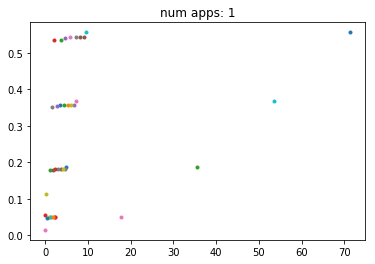

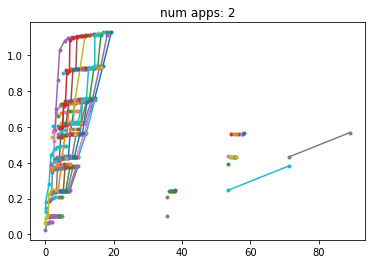

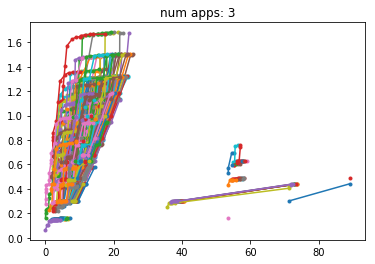

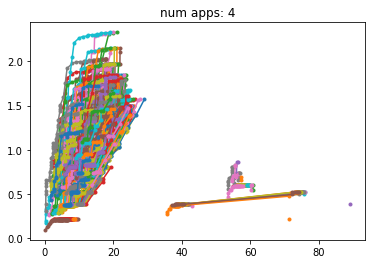

In [34]:
incoming = set()
for a, b in unique_edges:
    if id_stem(b) == "83.0808_1_1-((81. 4).)":
        incoming.add(id_stem(a))
# print incoming

for i, (dp, _) in enumerate(stats):
    plt.figure()
    for stem, v in dp.iteritems():
        if id_stem(stem) in incoming:
#             print 'num apps:', i, 'id_stem', id_stem(stem)
#             print len(v)
            pts = [(vv[1], vv[0][0]) for vv in v]
#             print(pts)
            x, y = zip(*pts)
            plt.plot(x, y, '.-')
#             print
    plt.title('num apps: {}'.format(i+1))
#     plt.xlim(None, 0)

In [32]:
with open('../output/mainstream/stems/{}-edges_weighted.csv'.format(run_id), 'w') as f:
    f.write('source,target,weight\n')
    for a, b in unique_edges:
        f.write(id_stem(a) + ',' + id_stem(b) + ',' + str(edge_weights[(id_stem(a), id_stem(b))]) + '\n')

with open('../output/mainstream/stems/{}-edges_weighted_scaled.csv'.format(run_id), 'w') as f:
    f.write('source,target,weight,weight_original,weight_a,weight_b\n')
    for a, b in unique_edges:
        weight = edge_weights[(id_stem(a), id_stem(b))]
        f.write('{},{},{:g},{},{},{}\n'.format(id_stem(a), id_stem(b), float(weight) / weights[id_stem(b)], weight, weights[id_stem(a)], weights[id_stem(b)]))

In [33]:
from collections import Counter
stem_lens = Counter()
for stem in nodes:
    stem_lens[len(stem.stem)] += 1
stem_lens

Counter({1: 118, 2: 726, 3: 702, 4: 126})